In [1]:
# Third party imports
import matplotlib.pyplot as plt
import numpy as np

# Settings
seed = 3 # chosen by fair dice roll. guaranteed to be random. https://xkcd.com/221/
np.random.seed(seed)
np.set_printoptions(edgeitems=30, linewidth=100000)

In [14]:
# Local application imports

import smile.smile as smile
from smile.smile import Population, PopulationList, Methodology, RegressionResult
from smile.example_populations import get_useful_poplists
import smile.helper as helper

# Population generation

In [3]:
pops_noerror, pops_adderror, pops_mulerror = get_useful_poplists(100)
    
pops_noerror.generate()
pops_mulerror.generate()
pops_adderror.generate()

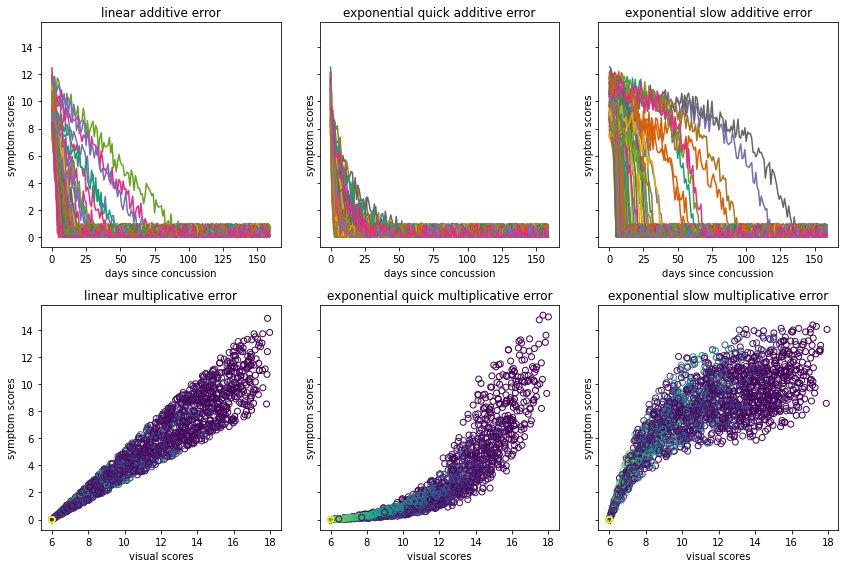

In [4]:
ncols = len(pops_noerror)
nrows = len([pops_mulerror, pops_adderror])

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=plt.figaspect(nrows/ncols)*2, sharey=True)
npersons=None
ndays=None

pops_mulerror.plot(axes[0, :], x='day', y='symptom', viztype='lines', vizcolor='person', npersons=npersons, ndays=ndays)
pops_adderror.plot(axes[1, :], x='visual', y='symptom', viztype='points', vizcolor='day', npersons=npersons, ndays=ndays)
    
plt.tight_layout()
plt.show()

# Study

## Comparing traditional studies

In [5]:
methodologies = [Methodology('trad short', [8, 15, 29]), Methodology('trad long', [8, 29, 90])]

meth_pops = []
for methodology in methodologies:
    meth_pops.append(methodology.sample(pops_mulerror))

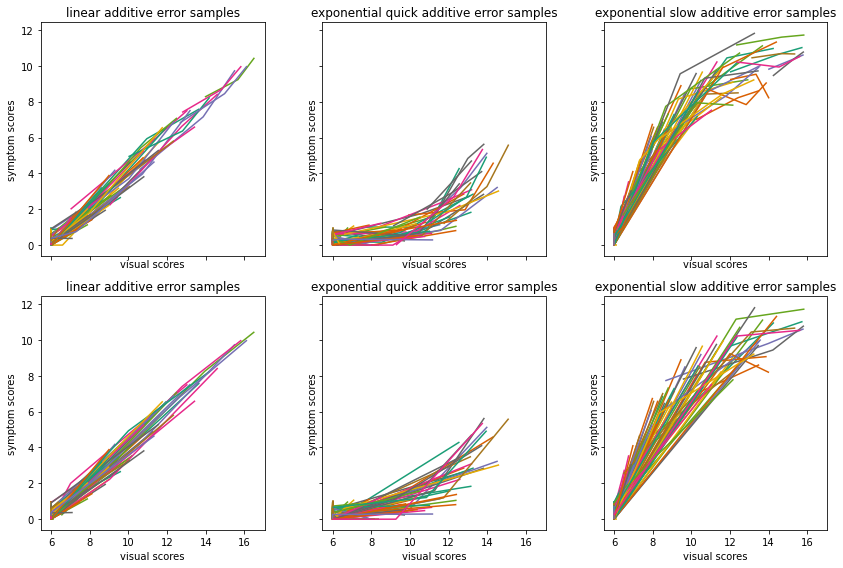

In [6]:
#TODO study name when plotting
ncols = len(meth_pops[0])
nrows = len(meth_pops)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=plt.figaspect(nrows/ncols)*2, sharex=True, sharey=True)
npersons=None
ndays=None

for row in range(nrows):
    meth_pops[row].plot(axes[row, :], x='visual', y='symptom', viztype='lines', vizcolor='person', npersons=npersons, ndays=ndays)
    
plt.tight_layout()
plt.show()

## Comparing traditional to smile studies

In [7]:
methodologies2 = [Methodology('trad short', [8, 15, 29, 90]), Methodology('smile', [8, 0.7, 0.4, 0.1])]

meth_pops2 = []
for methodology in methodologies2:
    meth_pops2.append(methodology.sample(pops_mulerror))

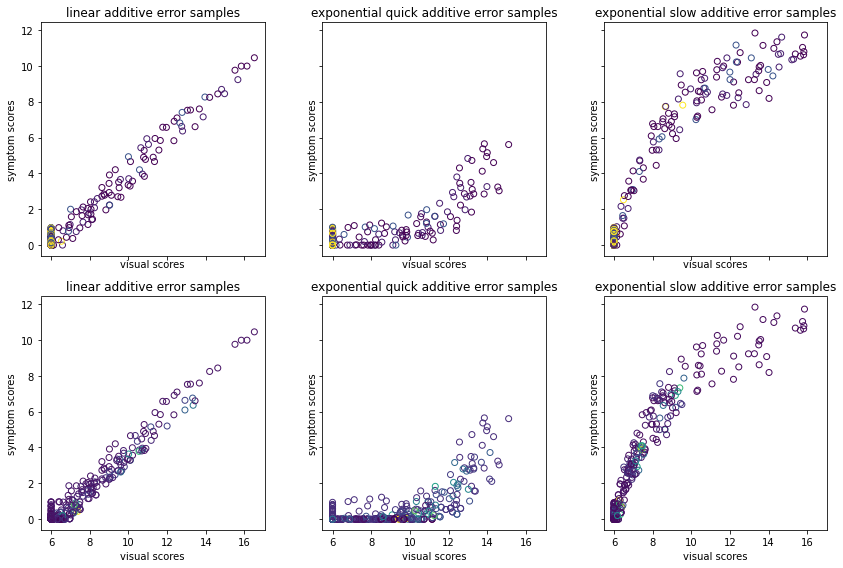

In [8]:
ncols = len(meth_pops2[0])
nrows = len(meth_pops2)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=plt.figaspect(nrows/ncols)*2, sharex=True, sharey=True)
npersons=None
ndays=None

for row in range(nrows):
    meth_pops2[row].plot(axes[row, :], x='visual', y='symptom', viztype='points', vizcolor='day', npersons=npersons, ndays=ndays)
    
plt.tight_layout()
plt.show()

## Regression test

In [9]:
poplist_reglists = []
for poplist in meth_pops2:
    reglists = poplist.regress_persons(x='visual', y='symptom')
    poplist_reglists.append(reglists)

C:\tools\Anaconda3\envs\smile\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


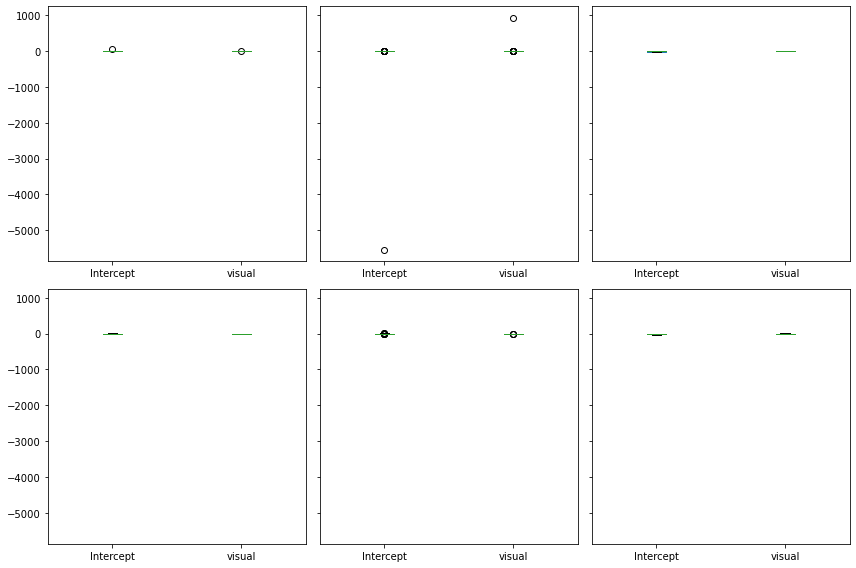

In [10]:
## ncols = len(meth_pops2[0])
nrows = len(meth_pops2)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=plt.figaspect(nrows/ncols)*2, sharey=True)

for row in range(nrows):
    for col in range(ncols):
        poplist_reglists[row][col].plot_box(axes[row, col])
        
plt.tight_layout()
plt.show()

In [15]:
import pandas as pd
with pd.option_context('display.float_format', lambda s: '{:8.2f}'.format(s)):
    for row in range(nrows):
        text_blocks = []
        for col in range(ncols):
            df = poplist_reglists[row][col].params_dataframe
            dfoutliers = pd.concat([df.min(), df.max()], axis=1)
            dfoutliers.columns = ["min", "max"]
            text_blocks.append(str(dfoutliers))
        print(helper.collocate_text(text_blocks))
        print()

               min      max		               min      max		               min      max
Intercept   -10.25    45.33		Intercept -5543.57    11.52		Intercept   -26.86     4.23
visual       -7.51     1.76		visual       -1.80   923.98		visual        0.00     4.50

               min      max		               min      max		               min      max
Intercept   -14.90     7.95		Intercept   -17.96    15.02		Intercept   -30.70     0.01
visual       -1.20     2.14		visual       -2.41     1.64		visual        0.00     5.12



In [17]:
import pandas as pd
with pd.option_context('display.float_format', lambda s: '{:8.2f}'.format(s)):
    for row in range(nrows):
        text_blocks = []
        for col in range(ncols):
            df = poplist_reglists[row][col].params_dataframe
            dfoutliers = pd.concat([df.idxmin(), df.idxmax()], axis=1)
            dfoutliers.columns = ["min", "max"]
            text_blocks.append(str(dfoutliers))
        print(helper.collocate_text(text_blocks))
        print()

           min  max		           min  max		           min  max
Intercept   94   40		Intercept   30   93		Intercept   67   34
visual      40   94		visual      93   30		visual      10   67

           min  max		           min  max		           min  max
Intercept   77    3		Intercept   99   64		Intercept    3   62
visual       3   77		visual      64   99		visual       7    3



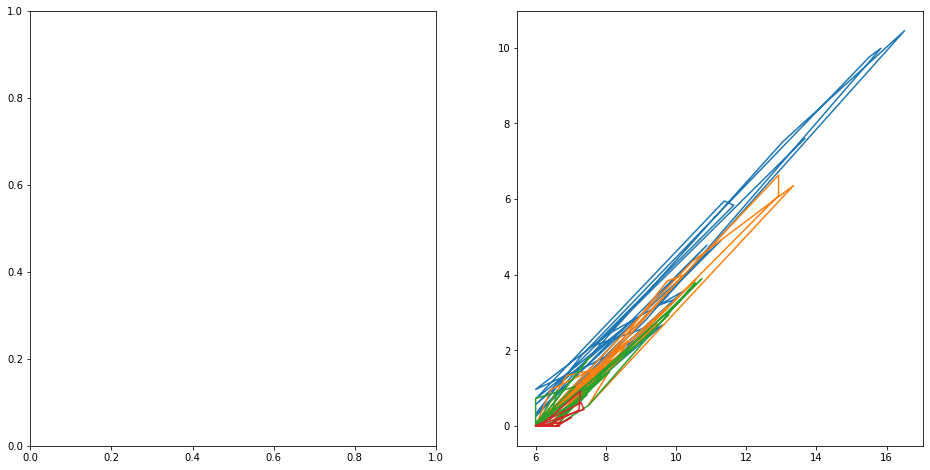

In [18]:
ncols=2
nrows=1
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=plt.figaspect(nrows/ncols)*2, squeeze=False)

vis = poplist[0].scores['visual'][0:30]
sym = poplist[0].scores['symptom'][0:30]

axes[0, 1].plot()
axes[0, 1].plot(vis, sym)

In [19]:
# TODO population to poplist for regress_persons and plot_person
# TODO put_side_by_side and print_side_by_side in helper.py